In [1]:
import pandas as pd
from datetime import timedelta

def read_from_csv(file_path):
    # 헤더 두 줄 읽기
    headers = pd.read_csv(file_path, skiprows=11, nrows=2, header=None).T
    upper = headers[0].ffill().tolist()
    lower = headers[1].tolist()

    # 컬럼명 생성
    combined_columns = [
        f"{str(u).strip()} {str(l).strip()}" if pd.notna(u) and pd.notna(l)
        else str(l).strip() or str(u).strip()
        for u, l in zip(upper, lower)
    ]
    
    # 본문 데이터 읽기
    df = pd.read_csv(file_path, skiprows=13, header=None)

    # 컬럼 수 맞추기
    min_len = min(len(combined_columns), df.shape[1])
    df = df.iloc[:, :min_len]
    df.columns = combined_columns[:min_len]

    # 전부 0인 컬럼 제거 + 중복 컬럼 제거
    df = df.loc[:, ~((df.fillna(0) == 0).all())]
    df = df.loc[:, ~df.columns.duplicated()]

    # KPI 키워드 필터링
    kpis = ["kbps", "MCS", "Wideband CQI", "RI", "PDU"]
    df = df.loc[:, [col for col in df.columns if any(k in col for k in kpis)]]

    # CodeWord0+1 포함된 것만 필터링
    df = df.loc[:, [col for col in df.columns if "CodeWord0+1" in col]]
    df.columns = df.columns.str.replace("CodeWord0\\+1", "", regex=True).str.strip()

    # 시간 컬럼 생성
    df_time = pd.read_csv(file_path, skiprows=4, nrows=3, header=None)
    log_start = df_time[df_time[0] == 'Logging Start Time'][1].values[0]
    log_start_dt = pd.to_datetime(log_start)
    # print("Logging Start Time:", log_start_dt)

    df = df.reset_index(drop=True)
    df['TIME_STAMP'] = [log_start_dt + timedelta(seconds=i) for i in range(len(df))]
    df['TIME_STAMP'] = df['TIME_STAMP'].dt.floor('s')
    df = df.reset_index().rename(columns={"index": "TIME_SEC"})
    
    return df

def read_from_xlsx(file_path):
    df_raw = pd.read_excel(file_path, sheet_name="Sheet1")
    df_cut = df_raw.filter(regex="^(TIME_STAMP|LTE KPI PCell )")
    df_cut.columns = [
        col if col == "TIME_STAMP" else col.replace("LTE KPI PCell ", "")
        for col in df_cut.columns
    ]

    df_cut = df_cut[df_cut["Serving PCI"] == 1].reset_index(drop=True)
    df_cut = df_cut[df_cut["Serving EARFCN(DL)"].isin([9560, 8790])].reset_index(drop=True)
    df_cut = df_cut[df_cut["Serving Band"].isin(["Band 28", "Band 26"])].reset_index(drop=True)

    df_kpi = df_cut.reset_index().rename(columns={"index": "TIME_SEC"})
    df_kpi['TIME_STAMP'] = df_kpi['TIME_STAMP'].dt.floor('s')
    
    return df_kpi

In [2]:
def weighted_avg(df, prefix):
    cols = [col for col in df.columns if col.startswith(prefix)]
    return df[cols].apply(
        lambda row: (
            sum(int(col.split('#')[1]) * row[col] for col in row.index if row[col] > 0) /
            sum(row[col] for col in row.index if row[col] > 0)
        ) if sum(row[col] for col in row.index if row[col] > 0) > 0 else pd.NA,
        axis=1
    )
    
def kpis_from_csv(file_path):
    df = read_from_csv(file_path)

    # MCS, CQI, RI 가중 평균
    df["MCS_avg"] = weighted_avg(df, "MCS#")
    df["CQI_avg"] = weighted_avg(df, "Wideband CQI#")
    df["RI_avg"]  = weighted_avg(df, "RI#")

    # BLER 계산
    total = df["Tx MAC PDU [PDUs]"]
    retrans = df["Tx Retrans MAC PDU [PDUs]"]
    discard = df["Tx Discarded MAC PDU [PDUs]"]
    df["BLER"] = ((retrans + discard) / total.replace(0, pd.NA)) * 100

    # '#숫자' 포함 컬럼 제거
    df = df.loc[:, ~df.columns.str.contains(r'#\d+')].copy()

    # 'PDU' 포함된 컬럼도 제거
    df = df.loc[:, ~df.columns.str.contains("PDU", case=False, na=False)]

    # 단위 변환 (kbps → Mbps)
    df.loc[:, "Tx Rate [kbps]"] = df["Tx Rate [kbps]"] / 1000
    df.loc[:, "Tx Throughput [kbps]"] = df["Tx Throughput [kbps]"] / 1000

    # 컬럼명 리네임
    rename_dict = {
        "TIME_SEC":"TIME_SEC",
        "TIME_STAMP":"TIME_STAMP",
        "Tx Rate [kbps]": "DL_PHY_Tput[Mbps]",
        "Tx Throughput [kbps]": "DL_MAC_Tput[Mbps]",
        "CQI_avg": "CQI",
        "MCS_avg": "DL_MCS",
        "RI_avg": "RI",
        "BLER":"DL_BLER[%]",
    }
    col_filtered = [col for col in rename_dict if col in df.columns]
    df = df[col_filtered].rename(columns=rename_dict)
    df.reset_index(drop=True, inplace=True)

    cutoff_idx = df[df["DL_MAC_Tput[Mbps]"] == 0].index.min()
    if pd.notna(cutoff_idx):
        df = df.loc[:cutoff_idx]
    
    return df

def kpis_from_xlsx(file_path):
    df = read_from_xlsx(file_path)

    if "WB RI2 Rate" in df.columns:
        df["WB RI"] = 1 + (df["WB RI2 Rate"] / 100)

    rename_dict = {
        "TIME_SEC":"TIME_SEC",
        "TIME_STAMP":"TIME_STAMP",
        "Serving RSRP [dBm]": "RSRP[dBm]",
        "Serving RSRQ [dB]": "RSRQ[dB]",
        "Serving RSSI [dBm]": "RSSI[dBm]",
        "SINR [dB]": "SINR[dB]",
        "WB CQI CW0": "CQI",
        "DL MCS0": "DL_MCS",
        "WB RI": "RI",
        "PDSCH BLER [%]": "DL_BLER[%]",
        "PDSCH Throughput [Mbps]": "DL_PHY_Tput[Mbps]",
        "MAC DL Throughput [Mbps]": "DL_MAC_Tput[Mbps]",
        "PDSCH PRB Number(Including 0)": "DL_RB_Num",
        # "WB RI2 Rate": "RI2_Rate[%]",
    }

    col_filtered = [col for col in rename_dict if col in df.columns]
    df = df[col_filtered].rename(columns=rename_dict)
    df.reset_index(drop=True, inplace=True)

    return df

In [3]:
import os
import pandas as pd
def concat_kpi_common(dfs):
    if not dfs:
        return pd.DataFrame()
    df = pd.concat(dfs, ignore_index=True)
    return df

def concat_kpi_from_csv(test_dir):
    directory_path = os.getcwd()
    input_path = os.path.join(directory_path, test_dir)

    # ✅ 대상 파일 수집
    csv_files = [
        f for f in os.listdir(input_path)
        if f.endswith(".csv") and '$' not in f and "concat" not in f
    ]

    # ✅ KPI 누적
    dfs = []
    for filename in csv_files:
        file_path = os.path.join(input_path, filename)
        file_tag = os.path.splitext(filename)[0]
        try:
            df_kpi = kpis_from_csv(file_path)
            df_kpi["UHD_Power"] = file_tag
            dfs.append(df_kpi)
        except Exception as e:
            print(f"❌ 처리 실패: {filename} → {e}")
    
    return concat_kpi_common(dfs)

def concat_kpi_from_xlsx(test_dir):
    directory_path = os.getcwd()
    input_path = os.path.join(directory_path, test_dir)

    # ✅ 대상 파일 수집
    excel_files = [
        f for f in os.listdir(input_path)
        if f.endswith(".xlsx") and '$' not in f and "concat" not in f
    ]

    # ✅ KPI 누적
    dfs = []
    for filename in excel_files:
        file_path = os.path.join(input_path, filename)
        file_tag = os.path.splitext(filename)[0]
        try:
            df_kpi = kpis_from_xlsx(file_path)
            df_kpi["UHD_Power"] = file_tag
            dfs.append(df_kpi)
        except Exception as e:
            print(f"❌ 처리 실패: {filename} → {e}")

    return concat_kpi_common(dfs)

In [4]:
import os
def assign_output_power(df, index_power, out_start, interval):
    unique_times = df["TIME_SEC"].drop_duplicates().sort_values().reset_index(drop=True)
    out_values = [out_start - i for i in range(len(unique_times) // interval + 1)]
    out_series = [v for v in out_values for _ in range(interval)][:len(unique_times)]
    time_to_power = dict(zip(unique_times, out_series))
    df[index_power] = df["TIME_SEC"].map(time_to_power)
    df = df.drop(columns=["TIME_SEC", "TIME_STAMP"])
    return df

def concat_all_kpi(test_dir, out_start, interval, rsrp_start=None):
    df_csv = concat_kpi_from_csv(test_dir)
    df_xlsx = concat_kpi_from_xlsx(test_dir)
    # display(df_csv)
    # print(df_csv.info())
    # display(df_xlsx)
    # print(df_xlsx.info())
    
    if df_xlsx.empty:
        df_merged = df_csv.copy()
    elif df_csv.empty:
        dfs = []
        for power_level in df_xlsx['UHD_Power'].unique():
            group_df = df_xlsx[df_xlsx['UHD_Power'] == power_level].reset_index(drop=True)
            rsrp0 = group_df["RSRP[dBm]"].iloc[0]
            for i, rsrp in enumerate(group_df["RSRP[dBm]"]):
                if abs(rsrp - rsrp0) > 0.5:
                    group_cut = group_df.iloc[i:].reset_index(drop=True)
                    group_cut['TIME_SEC'] = group_cut.index
                    break
            dfs.append(group_cut)
        df_merged = pd.concat(dfs, ignore_index=True)
    else:
        df_merged = pd.merge(df_csv, df_xlsx, on=["TIME_STAMP", "UHD_Power"], how="inner", suffixes=('_csv', '_xlsx'))
        for col in df_csv.columns:
            if col not in ["TIME_STAMP", "UHD_Power"] and f"{col}_xlsx" in df_merged.columns:
                df_merged[col] = df_merged[f"{col}_csv"]
        drop_cols = [col for col in df_merged.columns if col.endswith('_csv') or col.endswith('_xlsx')]
        df_merged.drop(columns=drop_cols, inplace=True)
        
    df = df_merged.sort_values(by=["TIME_SEC", "UHD_Power"]).reset_index(drop=True)
    # print(df.info())
    
    index_power = "output power [dBm]"
    index_rsrp = "clean RSRP [dBm]"

    if test_dir != '250710-ZFold7-wired-with-BPF':
        df = assign_output_power(df, index_power, out_start, interval)
    else:
        # print("out_start:", out_start, "interval:", interval)
        df_normal = df[~df['UHD_Power'].isin(['-10dBm', '-15dBm'])].copy()
        df_normal = assign_output_power(df_normal, index_power, out_start, interval)
        df_abnormal = df[df['UHD_Power'].isin(['-10dBm', '-15dBm'])].copy()
        df_abnormal = assign_output_power(df_abnormal, index_power, out_start, interval=10)
        df = pd.concat([df_normal, df_abnormal], ignore_index=True).reset_index(drop=True)
    # counts = df.groupby([index_power, "UHD_Power"]).size().reset_index(name="count")
    # counts = counts.sort_values(by=index_power, ascending=False).reset_index(drop=True)
    # display(counts.head(20))
    
    # anritsu max power = -45
    if out_start > -45:
        out_start = -45
        df = df[df[index_power] <= out_start]

    group_cols = [index_power, 'UHD_Power']    
    kpi_cols = [col for col in df.columns if col not in group_cols]
    df_binning = df.groupby(group_cols)[kpi_cols].mean()
    df_binning = df_binning.sort_index(level=group_cols, ascending=False)
    df = df_binning.copy()
    # display(df.head(30))

    # concat reset
    df = df.reset_index()
    
    if "RSRP[dBm]" in df.columns:
        clean_rsrp_map = df[df["UHD_Power"] == "clean"].set_index(index_power)["RSRP[dBm]"]
        df[index_rsrp] = df[index_power].map(clean_rsrp_map)

    # inno DM not available
    if df_xlsx.empty:
        if rsrp_start:
            delta = rsrp_start - out_start
            df[index_rsrp] = df[index_power] + delta
        else:
            print(f"!!!! please input rsrp_start for {test_dir}")

    clean_output_limit = df[df["UHD_Power"] == "clean"][index_power].unique()
    df = df[df[index_power].isin(clean_output_limit)].copy()

    # display(df)
    threshold = 0.15 # clean 150 kbps
    clean_tput_limit = df[(df["UHD_Power"] == "clean") & (df["DL_MAC_Tput[Mbps]"]>threshold)][index_power].min()
    df = df[df[index_power] >= clean_tput_limit].copy()
    # print(clean_tput_limit)
    # display(df[df['UHD_Power']=='clean'])

    # print(df.info())
    # display(df)
    float_cols = ["CQI", "RI", "DL_MCS", "DL_BLER[%]"]
    for col in float_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.round(2)

    df = df.dropna().reset_index(drop=True)
    # display(df)
 
    # output_path = os.path.join(test_dir, f"{test_dir}_concat.xlsx")
    # df.to_excel(output_path, index=True, float_format="%.2f")

    return df

In [5]:
import matplotlib.pyplot as plt
import math
import numpy as np
import os
from matplotlib.ticker import MultipleLocator, FixedLocator

def plot_kpis(test_dir, out_start, interval, rsrp_start, rsrp_class='all'):

    df = concat_all_kpi(test_dir=test_dir, out_start=out_start, interval=interval, rsrp_start=rsrp_start)
    index_power = "output power [dBm]"
    index_rsrp = "clean RSRP [dBm]"

    x_col = index_rsrp if index_rsrp in df.columns else index_power

    x_start = df[x_col].max()
    x_end = df[x_col].min()
    # if 'wired' in test_dir:
    #     x_end = -132
    # elif 'wireless' in test_dir:
    #     x_end = -126

    x_mid = x_start - (x_start - x_end) / 2
    x_edge = x_end + (x_start - x_end) / 3
    
    if rsrp_class == 'high':
        x_end = x_mid
    elif rsrp_class == 'low':
        x_start = x_mid
    elif rsrp_class == 'edge':
        x_start = x_edge
    
    df = df[(df[x_col] <= x_start) & (df[x_col] >= x_end)]
    
    start_tick = int(math.ceil(x_start / 5.0)) * 5
    end_tick = int(math.floor(x_end / 5.0)) * 5
    xtick_labels = list(range(start_tick, end_tick - 1, -5))

    unique_powers = df["UHD_Power"].unique().tolist()
    def power_sort_key(col):
        if col == "clean":
            return -999
        elif "dBm" in col and col.replace("dBm", "").lstrip("-").isdigit():
            return int(col.replace("dBm", ""))
        else:
            return 0
    sorted_powers = sorted(unique_powers, key=power_sort_key)
    source_order = {power: idx + 1 for idx, power in enumerate(sorted_powers)}
    # print(source_order)

    style_map = {}
    cmap = plt.get_cmap("tab20b")    
    base_sources = [s for s in source_order if s not in ['clean']]
    num_base = len(base_sources)
    base_colors = [cmap(i / 20) for i in np.linspace(4, 19, num=num_base, dtype=int)]
    base_markers = ['s', 'D', '^', 'v', '<', '>', '*', 'P', 'X', '.', ',', '1', '2', '3', '4']

    style_map['clean'] = {'color': 'blue', 'linestyle': '-', 'linewidth': 1, 'marker': 'o'}  
    for i, s in enumerate(base_sources):
        style_map[s] = {
            'color': base_colors[i % len(base_colors)],
            'linestyle': '-',
            'linewidth': 1,
            'marker': base_markers[i % len(base_markers)]
        }
    
    def plot_kpi_group(kpi_dict, n_rows, n_cols, filename):
        subplot_width, subplot_height = 7, 6
        figsize = (n_cols * subplot_width, n_rows * subplot_height + 1)
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
        plt.subplots_adjust(hspace=0.5, wspace=0.5)
        axs = axs.flatten()

        for i, (kpi, cfg) in enumerate(kpi_dict.items()):
            ax = axs[i]
            for j, source in enumerate(source_order):
                subset = df[df["UHD_Power"] == source].sort_values(by=index_power, ascending=False)
                style = style_map[source]
                ax.plot(
                    subset[x_col], subset[kpi],
                    marker=style['marker'],
                    markersize = 3,
                    color=style['color'],
                    label=source,
                    linestyle=style['linestyle'],
                    linewidth=style['linewidth'],
                )

            ax.set_title(cfg["title"], fontsize=15, weight="bold", pad=5)
            ax.set_xlabel(f"{x_col}", fontsize=13)
            ax.set_ylabel(cfg["ylabel"], fontsize=13, labelpad=5)
            ax.tick_params(axis='x', labelrotation=45, labelsize=10)
            ax.tick_params(axis='y', labelsize=10)
            ax.set_xticks(xtick_labels)
            ax.set_xticklabels(xtick_labels)
            ax.set_xlim(x_start + 1, x_end - 1)

            if rsrp_class in ['edge', 'low']:
                ax.xaxis.set_major_locator(MultipleLocator(5))
                ax.xaxis.set_minor_locator(MultipleLocator(1))
                if "RSRP[dBm]" in kpi_dict:
                    ax.yaxis.set_major_locator(MultipleLocator(5))
                    ax.yaxis.set_minor_locator(MultipleLocator(1))
                    ax.grid(True, which='major', axis='both', linestyle='--', linewidth=0.7, alpha=0.9)
                    ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5, alpha=0.6)
                else:
                    ax.grid(True, which='major', axis='x', linestyle='--', linewidth=0.7, alpha=0.9)
                    ax.grid(True, which='minor', axis='x', linestyle=':', linewidth=0.5, alpha=0.6)
                    ax.grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.9)
            else:
                ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.6)
            ax.legend(loc="best", fontsize=10)

        title_range = {
            'all': "Full Range",
            'high': "High Range",
            'low': "Low Range",
            'edge': "Edge Range",
        }
        if 'RSRP[dBm]' in kpi_dict:
            fig.suptitle(f"{test_dir}: Rx Quality [{title_range[rsrp_class]}]",fontsize=18, weight='bold', y=1.0)
        else:
            fig.suptitle(f"{test_dir}: DL KPI Trends",fontsize=18, weight='bold', y=1.0)
        plt.tight_layout()
        plt.savefig(os.path.join(test_dir, filename), dpi=150, bbox_inches='tight', pad_inches=0.3)
        plt.show()

    group_csv = {
        # "DL_PHY_Tput[Mbps]": {"ylabel": "DL PHY Throughput [Mbps]", "title": "DL PHY Throughput"},
        # "DL_MAC_Tput[Mbps]": {"ylabel": "DL MAC Throughput [Mbps]", "title": "DL MAC Throughput"},
        "CQI": {"ylabel": "CQI", "title": "CQI"},
        "DL_MCS": {"ylabel": "DL MCS Index", "title": "MCS"},
        "RI": {"ylabel": "RI", "title": "Rank Indicator"},
        "DL_BLER[%]": {"ylabel": "DL BLER [%]", "title": "BLER"},

    }
    group_xlsx = {
        "RSRP[dBm]": {"ylabel": "RSRP [dBm]", "title": "RSRP"},
        "RSRQ[dB]": {"ylabel": "RSRQ [dB]", "title": "RSRQ"},
        "SINR[dB]": {"ylabel": "SINR [dB]", "title": "SINR"},
        "RSSI[dBm]": {"ylabel": "RSSI [dBm]", "title": "RSSI"},
    }

    if "RSRP[dBm]" in df.columns:
        plot_kpi_group(group_xlsx, n_rows=2, n_cols=2, filename=f"{test_dir}_rx_quality_{rsrp_class}.png")

    if rsrp_class == 'all':
        plot_kpi_group(group_csv, n_rows=2, n_cols=2, filename=f"{test_dir}_kpis.png")

    return df

In [6]:
# df = plot_kpis(test_dir="wired-ZFold7-QCT-without-BPF", out_start=-60, interval=5, rsrp_start=None, rsrp_class='all')
# df = plot_kpis(test_dir="wired-ZFold7-QCT-with-BPF", out_start=-60, interval=7, rsrp_start=None, rsrp_class='all')
# df = plot_kpis(test_dir="wireless-ZFold7-QCT", out_start=-40, interval=10, rsrp_start=None, rsrp_class='all')
# df = plot_kpis(test_dir="wireless-ZFlip7-LSI", out_start=-40, interval=10, rsrp_start=None, rsrp_class='all')
# df = plot_kpis(test_dir="wireless-iPhone15ProMax-QCT", out_start=-40, interval=10, rsrp_start=None, rsrp_class='all')
# df = plot_kpis(test_dir="wireless-iPhone16e-Apple", out_start=-40, interval=10, rsrp_start=-68, rsrp_class='all')
# df = plot_kpis(test_dir="wireless-Buddy3-MTK", out_start=-40, interval=10, rsrp_start=-76, rsrp_class='all')
# display(df)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os

def plot_tput(test_dir, out_start, interval, rsrp_start, rsrp_class='all', Max5=True):  
    
    df = concat_all_kpi(test_dir=test_dir, out_start=out_start, interval=interval, rsrp_start=rsrp_start)
    index_power = "output power [dBm]"
    index_rsrp = "clean RSRP [dBm]"
    # display(df)
    
    x_col = index_rsrp if index_rsrp in df.columns else index_power
    
    x_start = df[x_col].max()
    x_end = df[x_col].min()
    
    x_mid = x_start - (x_start - x_end) / 2
    x_edge = x_end + (x_start - x_end) / 3
    
    if rsrp_class == 'high':
        x_end = x_mid
    elif rsrp_class == 'low':
        x_start = x_mid
    elif rsrp_class == 'edge':
        x_start = x_edge
    elif rsrp_class == 'all':
        x_start = -75
    
    df = df[(df[x_col] <= x_start) & (df[x_col] >= x_end)]

    start_tick = int(math.ceil(x_start / 5.0)) * 5
    end_tick = int(math.floor(x_end / 5.0)) * 5
    xtick_labels = list(range(start_tick, end_tick - 1, -5))

    abs_df = df.groupby([x_col, "UHD_Power"])["DL_MAC_Tput[Mbps]"].mean().unstack()
    # abs_df["BW 10MHz"] = (abs_df["clean"] * 0.5)
    # abs_df["BW 15MHz"] = (abs_df["clean"] * 0.75)

    rel_df = abs_df.divide(abs_df["clean"], axis=0) * 100
    rel_df = rel_df[rel_df["clean"].notna()] # after clean call drop
    # display(abs_df)
    # display(rel_df)

    unique_powers = abs_df.columns
    def power_sort_key(col):
        if col == "clean":
            return -999
        elif col == "BW 15MHz":
            return 999
        elif col == "BW 10MHz":
            return 1000
        elif "dBm" in col and col.replace("dBm", "").lstrip("-").isdigit():
            return int(col.replace("dBm", ""))
        else:
            return 0
    sorted_powers = sorted(unique_powers, key=power_sort_key)
    source_order = {power: idx + 1 for idx, power in enumerate(sorted_powers)}
    # print(source_order)

    device = test_dir.split('-')[0]
    if 'wireless' in test_dir:
        if Max5:
            output_path = f"_Max-5_{device}.png"
        else:
            del source_order['-5dBm']
            output_path = f"_Max-10_{device}.png"
    elif 'wired' in test_dir:
        if 'with BPF' in test_dir:
            output_path = f'_wired_wBPF_{device}.png'
        elif 'without BPF' in test_dir:
            output_path = f'_wired_woBPF_{device}.png'
    print(test_dir)
    print(device)
    print(output_path)
    
    style_map = {}
    cmap = plt.get_cmap("tab20b")    
    base_sources = [s for s in source_order if s not in ['clean', 'BW 15MHz', 'BW 10MHz']]
    num_base = len(base_sources)
    if "wired" in test_dir:
        num_base = 7
    base_colors = [cmap(i / 20) for i in np.linspace(4, 19, num=num_base, dtype=int)]
    base_markers = ['s', 'D', '^', 'v', '<', '>', '*', 'P', 'X', '.', ',', '1', '2', '3', '4']
    
    style_map['clean'] = {'color': 'blue', 'linestyle': '-', 'linewidth': 1, 'marker': 'o'}    
    if 'BW 15MHz' in source_order:
        style_map['BW 15MHz'] = {'color': 'skyblue', 'linestyle': ':', 'linewidth': 2, 'marker': None}
    if 'BW 10MHz' in source_order:
        style_map['BW 10MHz'] = {'color': 'skyblue', 'linestyle': ':', 'linewidth': 2, 'marker': None}
        
    for i, s in enumerate(base_sources):
        style_map[s] = {
            'color': base_colors[i % len(base_colors)],
            'linestyle': '-',
            'linewidth': 1,
            'marker': base_markers[i % len(base_markers)]
        }

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    plt.subplots_adjust(wspace=0.5, hspace=0.3)
    ax1, ax2 = axs.flatten()
    
    # ➤ 1. 절대값 (Mbps)
    for i, source in enumerate(source_order):
        if source not in abs_df.columns:
            continue
        style = style_map[source]
        ax1.plot(
            abs_df.index,
            abs_df[source],
            marker=style['marker'],
            markersize=3,
            color=style['color'],
            label=source,
            linestyle=style['linestyle'],
            linewidth=style['linewidth'],
        )

    ax1.set_title("DL Throughput", fontsize=14, weight='bold')
    ax1.set_xlabel("RSRP [dBm]", fontsize=12)
    ax1.set_ylabel("DL Throughput [Mbps]", fontsize=12)
    ax1.set_xticks(xtick_labels)
    ax1.set_xticklabels(xtick_labels, rotation=45)
    ax1.set_xlim(x_start + 1, x_end - 1)
    ax1.set_ylim(-10, 210)
    if rsrp_class in ['edge', 'low']:
        ax1.xaxis.set_major_locator(MultipleLocator(5))
        ax1.xaxis.set_minor_locator(MultipleLocator(1))
        ax1.grid(True, which='major', axis='x', linestyle='--', linewidth=0.7, alpha=0.9)
        ax1.grid(True, which='minor', axis='x', linestyle=':', linewidth=0.5, alpha=0.6)
        ax1.grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.9)
    else:
        ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.6)
    ax1.legend(loc="lower left" if rsrp_class == 'all' else "best", fontsize=10)

    # 기준선
    if rsrp_class in ['low', 'edge']:
        y_val = 15
        ax1.axhline(y=y_val, color='black', linestyle='--', linewidth=1.5)
        ax1.text(ax1.get_xlim()[1] + 1, y_val + 0.5, f"{y_val} Mbps", fontsize=11,
                color='black', verticalalignment='bottom', horizontalalignment='right')

    # ➤ 2. 상대값 (%)
    for i, source in enumerate(source_order):
        if source not in rel_df.columns:
            continue
        style = style_map[source]
        ax2.plot(
            rel_df.index,
            rel_df[source],
            marker=style['marker'],
            markersize=3,
            color=style['color'],
            label=source,
            linestyle=style['linestyle'],
            linewidth=style['linewidth'],
        )
    # ax2.axhline(100, color='blue', linestyle='--', linewidth=1)

    ax2.set_title("DL Relative Tput (% of Clean)", fontsize=14, weight='bold')
    ax2.set_xlabel("RSRP [dBm]", fontsize=12)
    ax2.set_ylabel("DL Relative Throughput [%]", fontsize=12)
    ax2.set_xticks(xtick_labels)
    ax2.set_xticklabels(xtick_labels, rotation=45)
    ax2.set_xlim(x_start + 1, x_end - 1)
    ax2.set_ylim(-5, 105)
    ax2.set_yticks(np.arange(0, 105, 10))
    if rsrp_class in ['edge', 'low']:
        ax2.xaxis.set_major_locator(MultipleLocator(5))
        ax2.xaxis.set_minor_locator(MultipleLocator(1))
        ax2.grid(True, which='major', axis='x', linestyle='--', linewidth=0.7, alpha=0.9)
        ax2.grid(True, which='minor', axis='x', linestyle=':', linewidth=0.5, alpha=0.6)
        ax2.grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.9)
    else:
        ax2.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.6)
    ax2.legend(loc="lower left" if rsrp_class == 'all' else "best", fontsize=10)

    title_range = {
        'all': "Full Range",
        'high': "High Range",
        'low': "Low Range",
        'edge': "Edge Range",
    }
    title = test_dir.replace('-', ' / ')
    fig.suptitle(f"{title}", fontsize=15, weight='bold', y=0.96)

    plt.tight_layout(rect=[0, 0, 1, 0.97])

    plt.savefig(output_path, dpi=150)
    plt.show()

    return abs_df, rel_df

GalaxyZFold7-QCT-SM8750(x80) [wired][with BPF]
GalaxyZFold7
_wired_wBPF_GalaxyZFold7.png


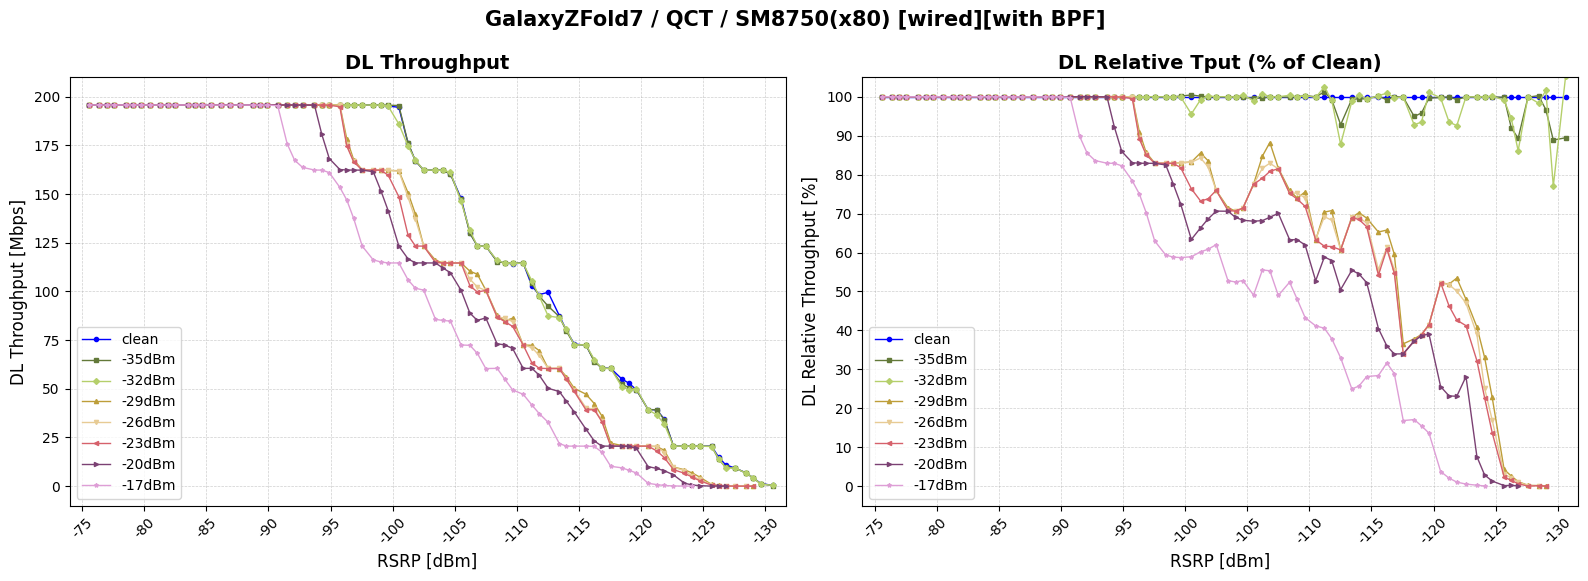

GalaxyZFold7-QCT-SM8750(x80) [wired][without BPF]
GalaxyZFold7
_wired_woBPF_GalaxyZFold7.png


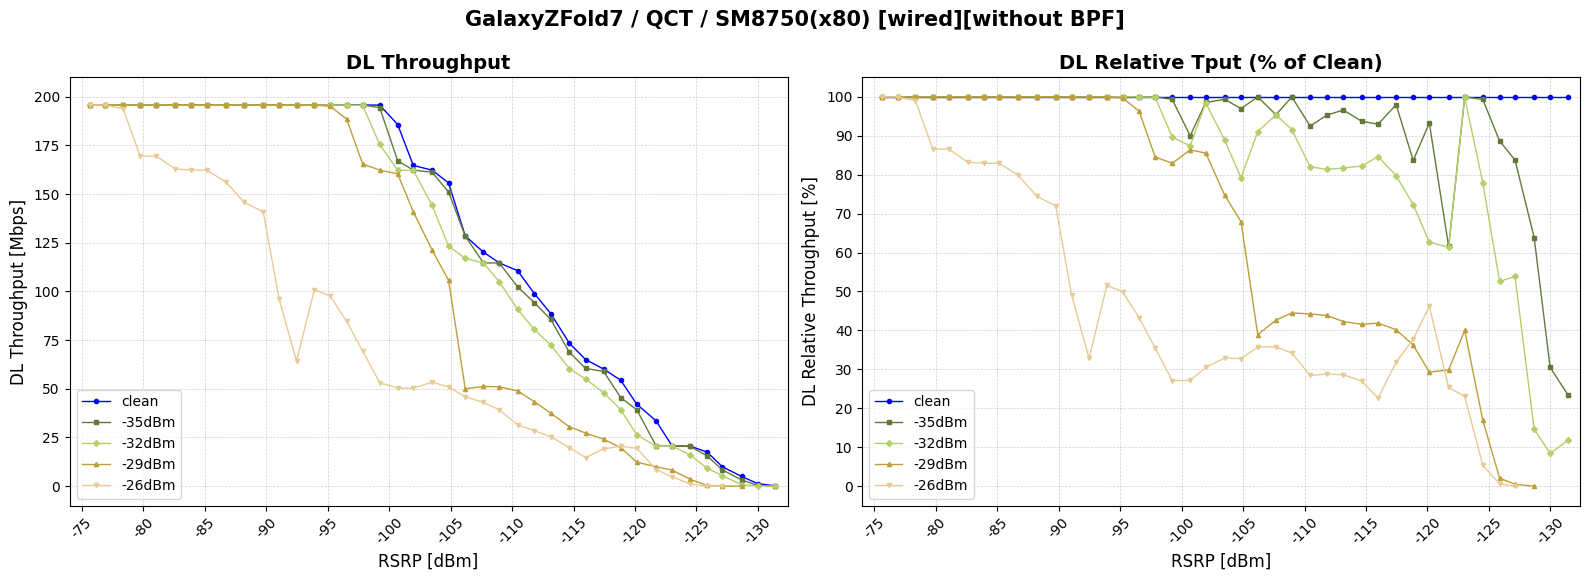

GalaxyZFlip7-LSI-E2500 [wireless]
GalaxyZFlip7
_Max-5_GalaxyZFlip7.png


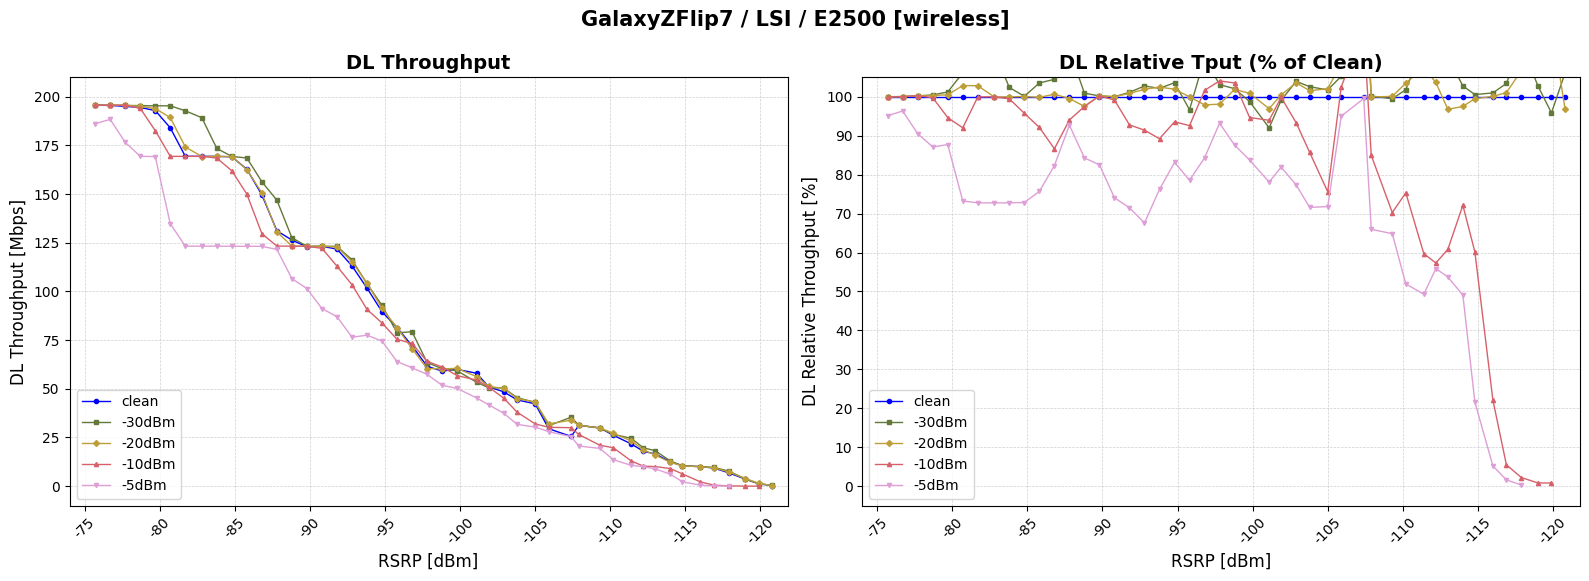

GalaxyZFlip7-LSI-E2500 [wireless]
GalaxyZFlip7
_Max-10_GalaxyZFlip7.png


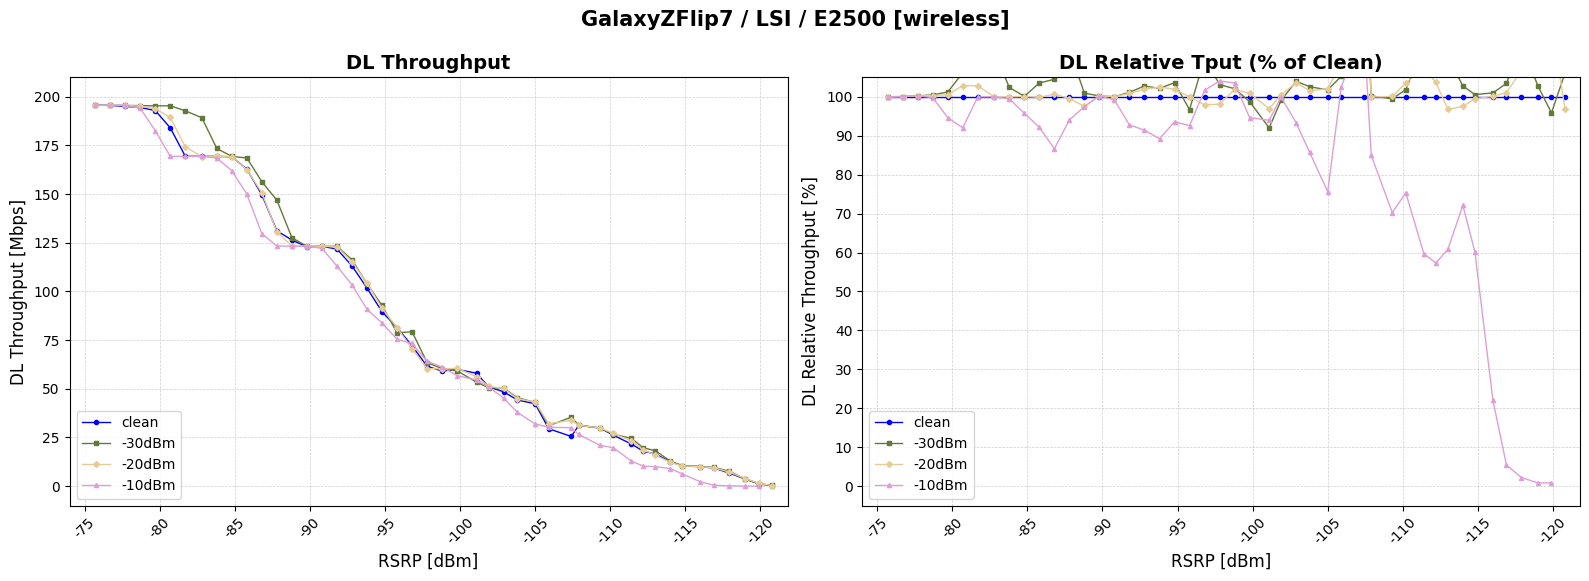

GalaxyZFold7-QCT-SM8750(x80) [wireless]
GalaxyZFold7
_Max-5_GalaxyZFold7.png


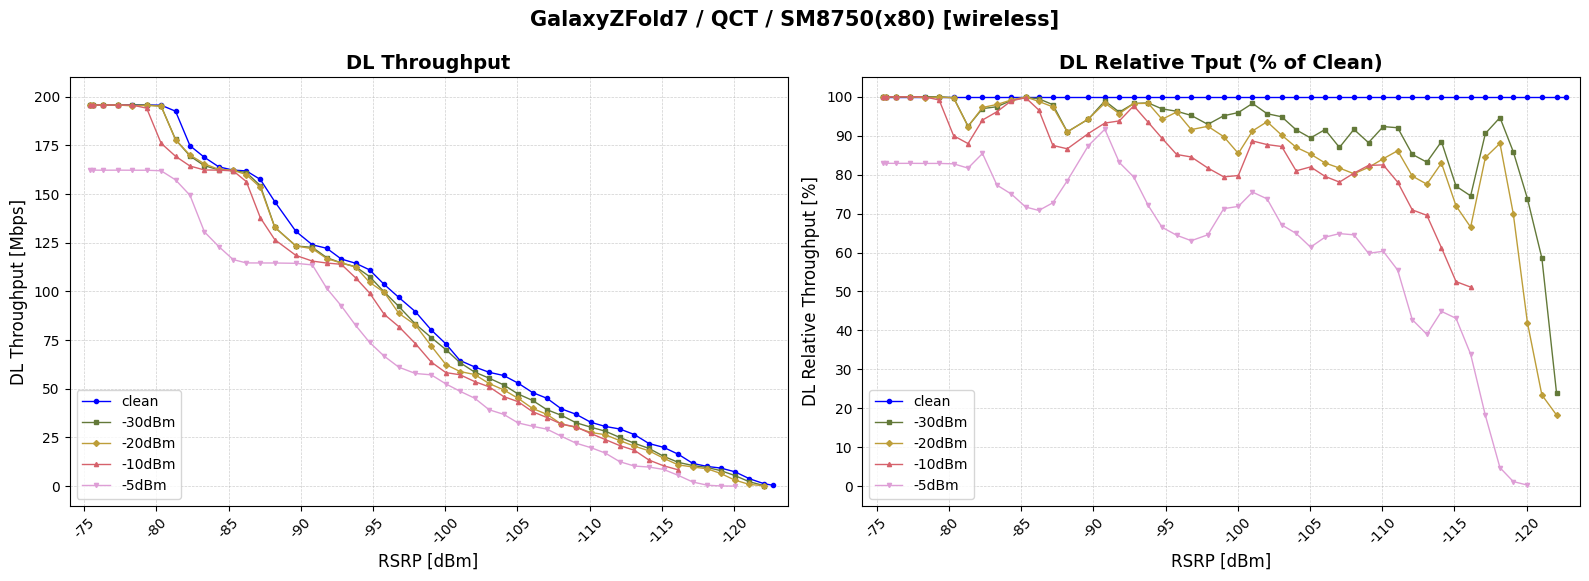

GalaxyZFold7-QCT-SM8750(x80) [wireless]
GalaxyZFold7
_Max-10_GalaxyZFold7.png


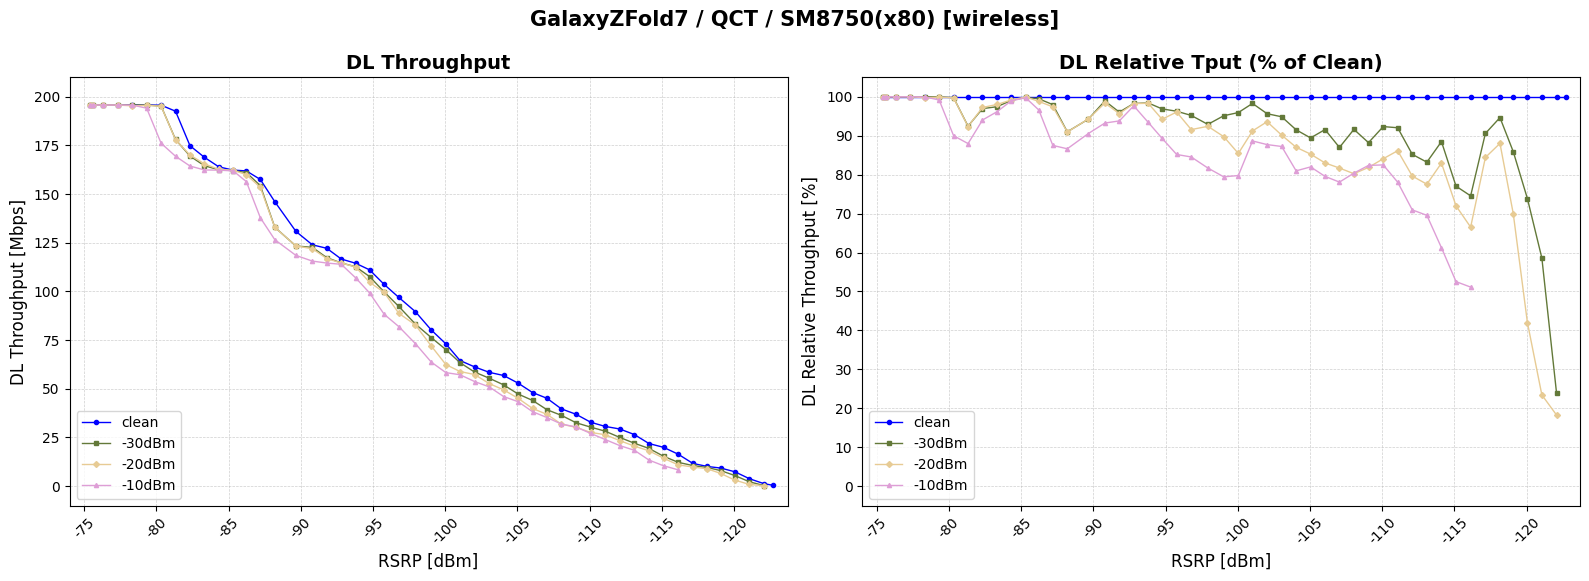

iPhone16e-Apple-A18(C1) [wireless]
iPhone16e
_Max-5_iPhone16e.png


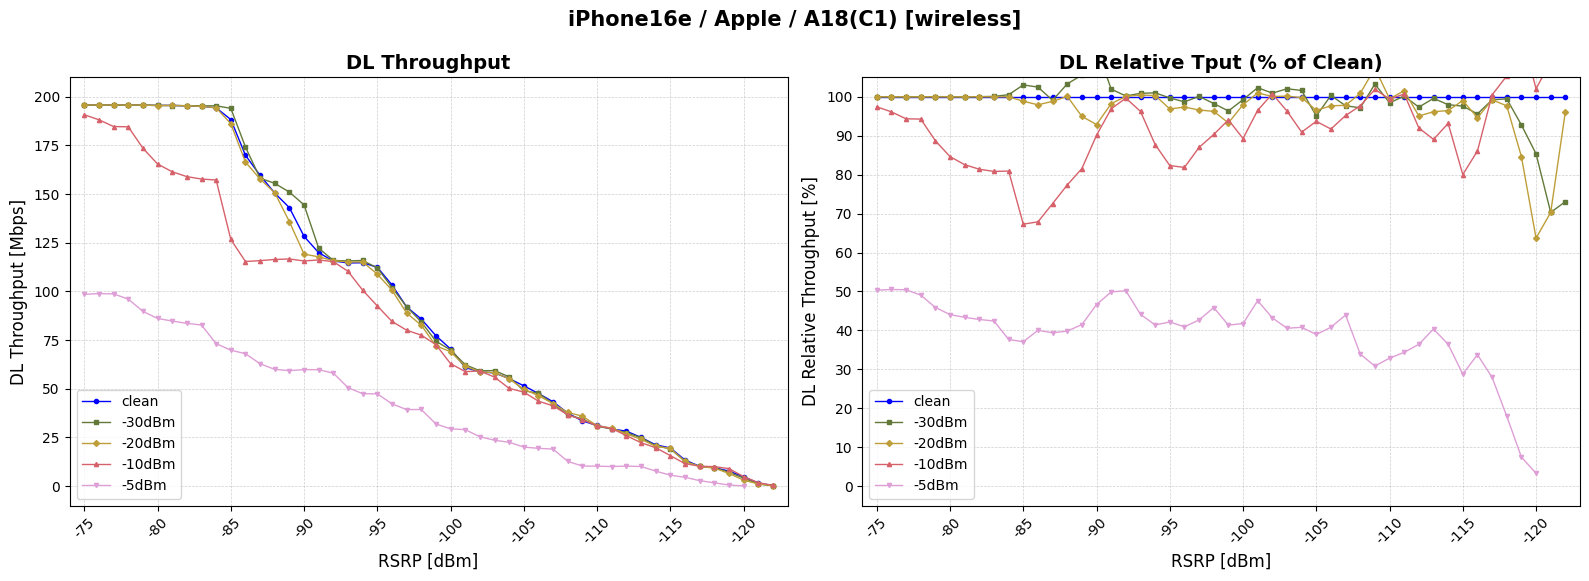

iPhone16e-Apple-A18(C1) [wireless]
iPhone16e
_Max-10_iPhone16e.png


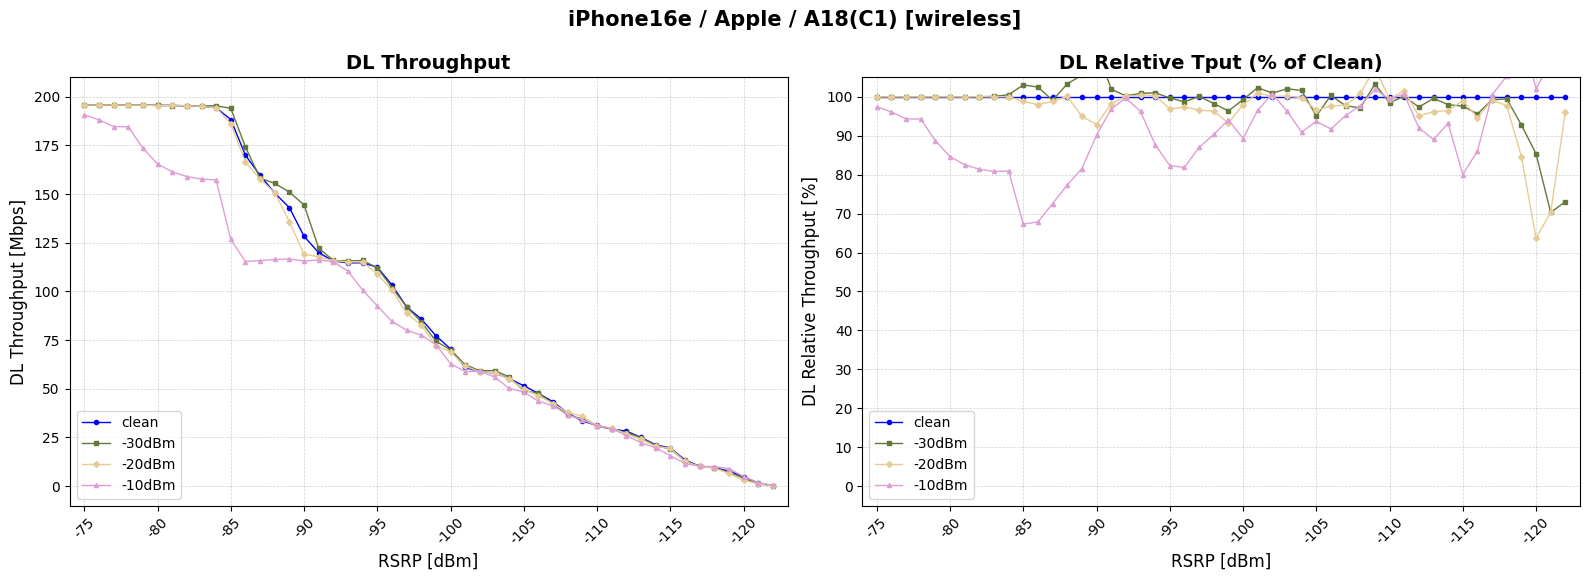

iPhone15ProMax-QCT-A17pro(x70) [wireless]
iPhone15ProMax
_Max-5_iPhone15ProMax.png


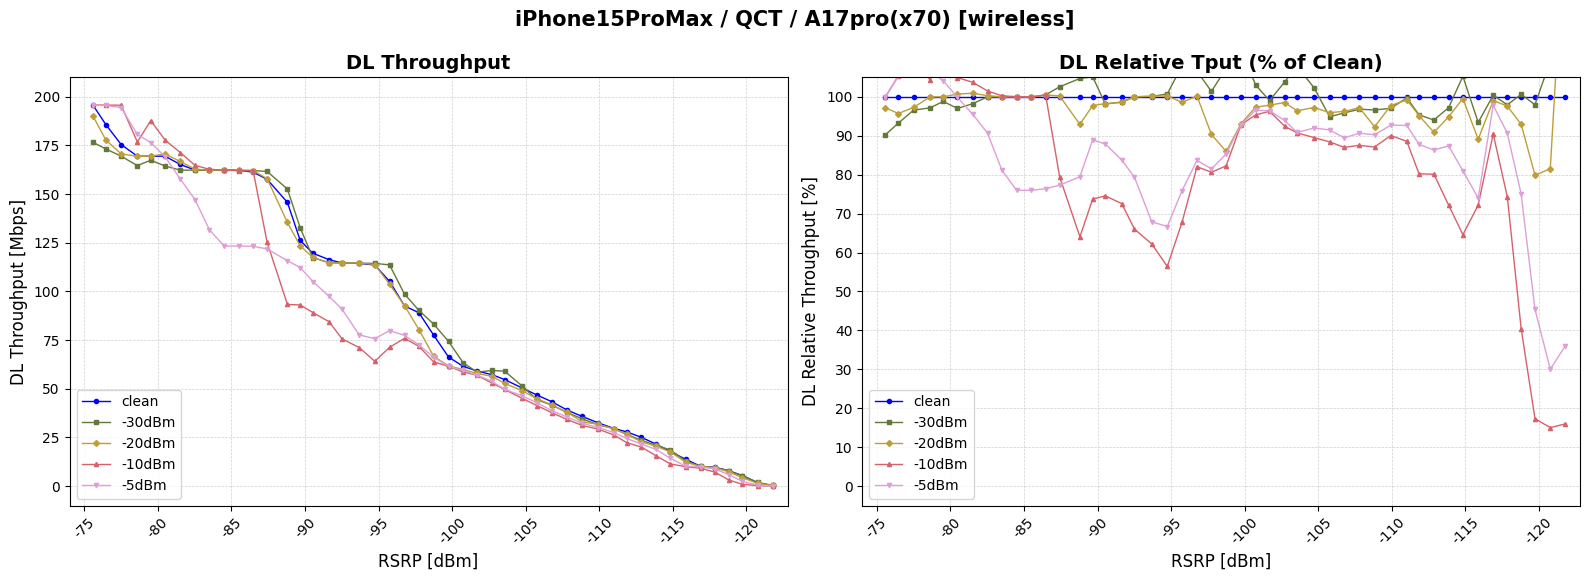

iPhone15ProMax-QCT-A17pro(x70) [wireless]
iPhone15ProMax
_Max-10_iPhone15ProMax.png


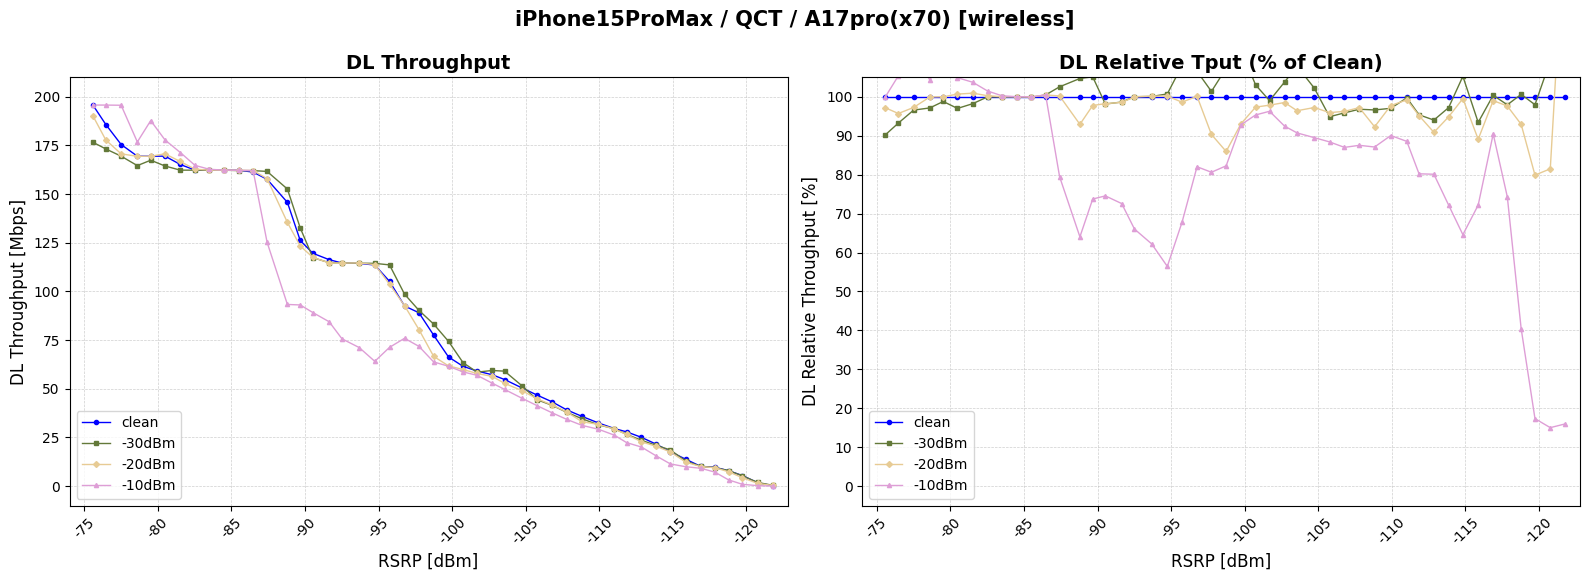

GalaxyBuddy3-MTK-D6100 [wireless]
GalaxyBuddy3
_Max-5_GalaxyBuddy3.png


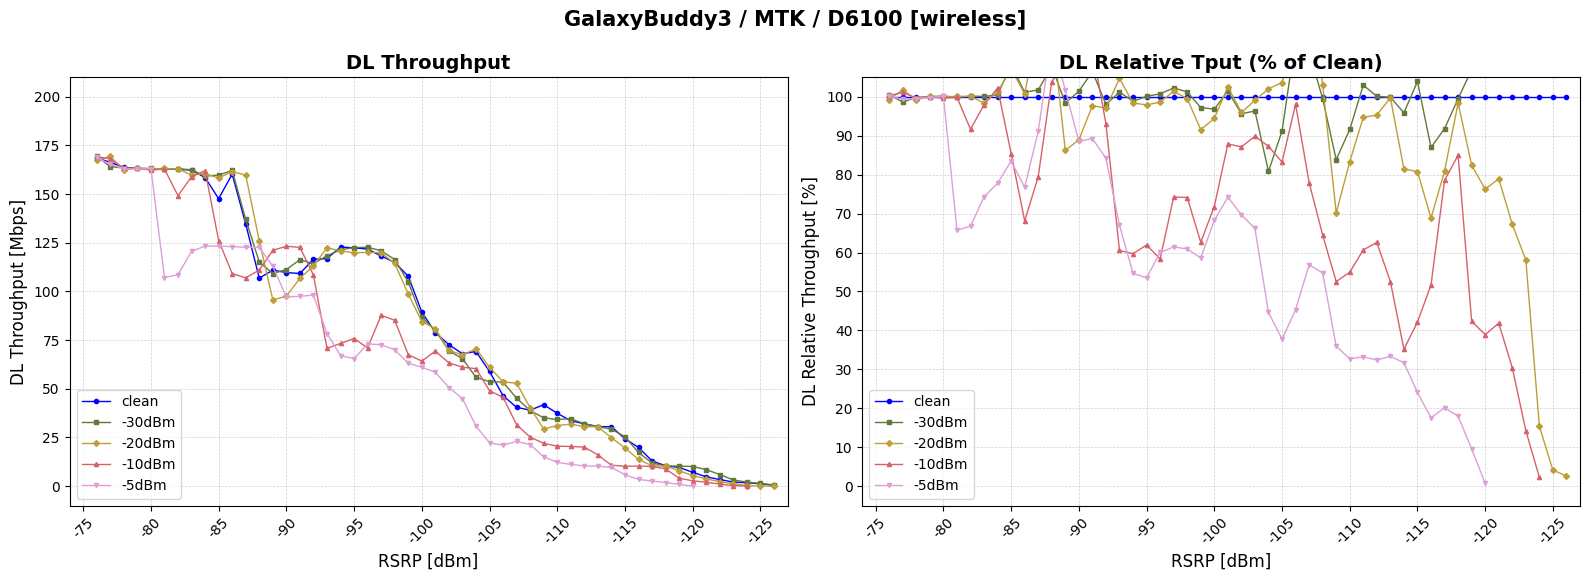

GalaxyBuddy3-MTK-D6100 [wireless]
GalaxyBuddy3
_Max-10_GalaxyBuddy3.png


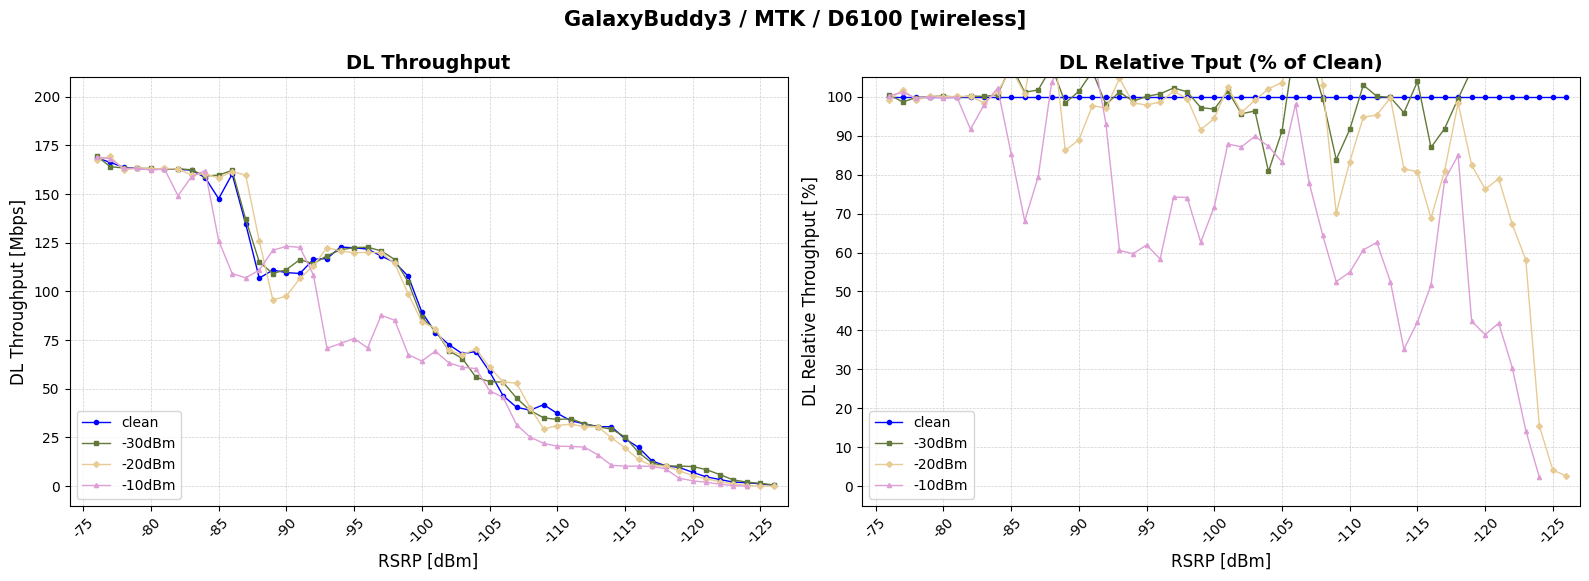

GalaxyTabS10Plus-MTK-D9300 [wireless]
GalaxyTabS10Plus
_Max-5_GalaxyTabS10Plus.png


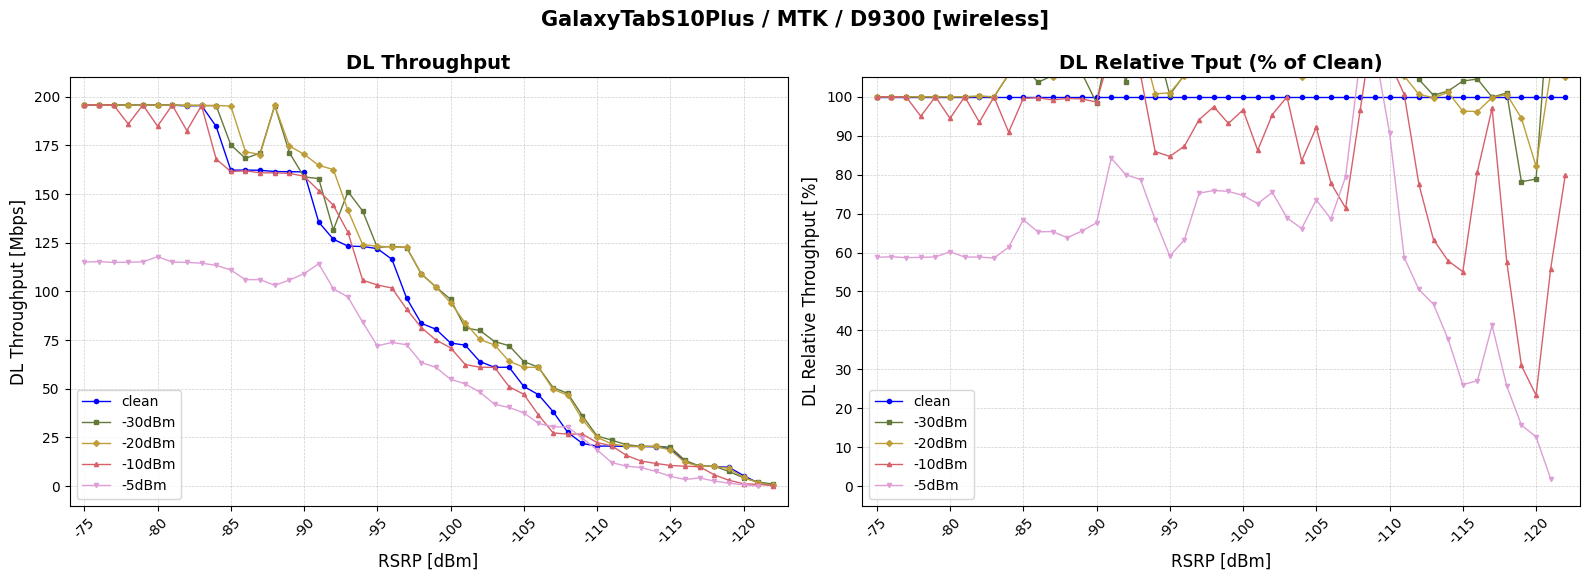

GalaxyTabS10Plus-MTK-D9300 [wireless]
GalaxyTabS10Plus
_Max-10_GalaxyTabS10Plus.png


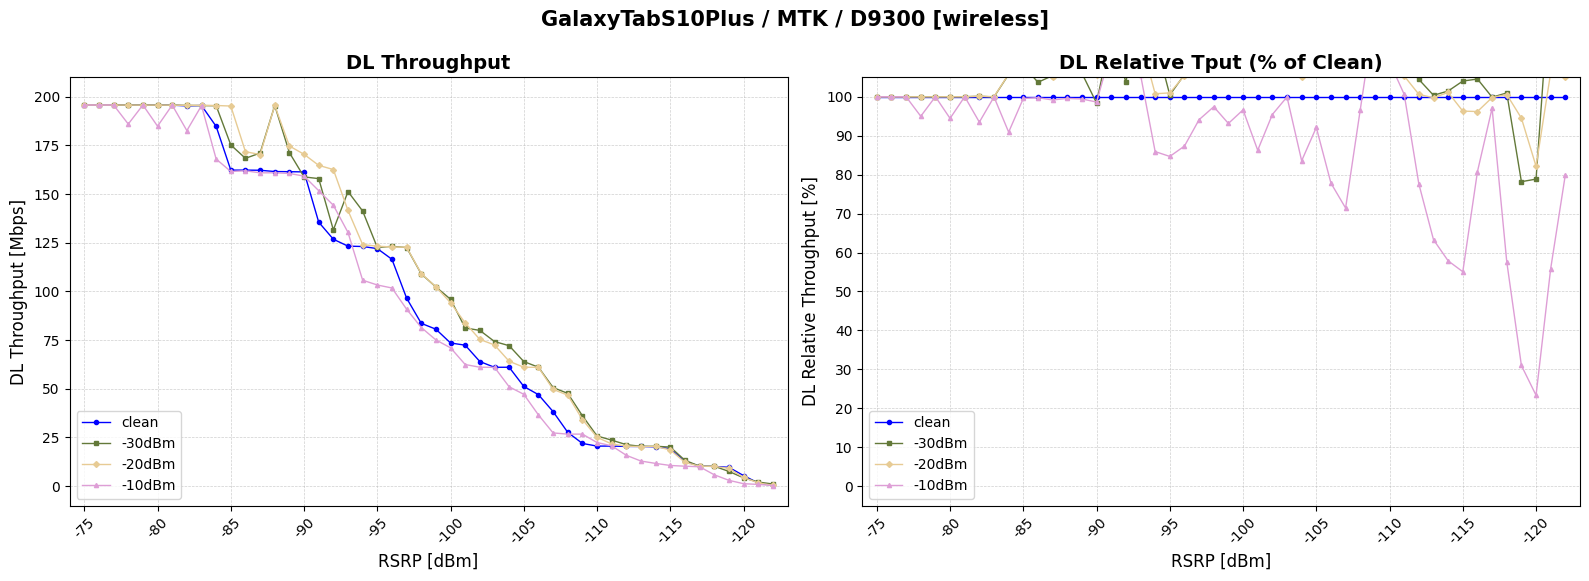

GalaxyA34-MTK-D1080 [wireless]
GalaxyA34
_Max-5_GalaxyA34.png


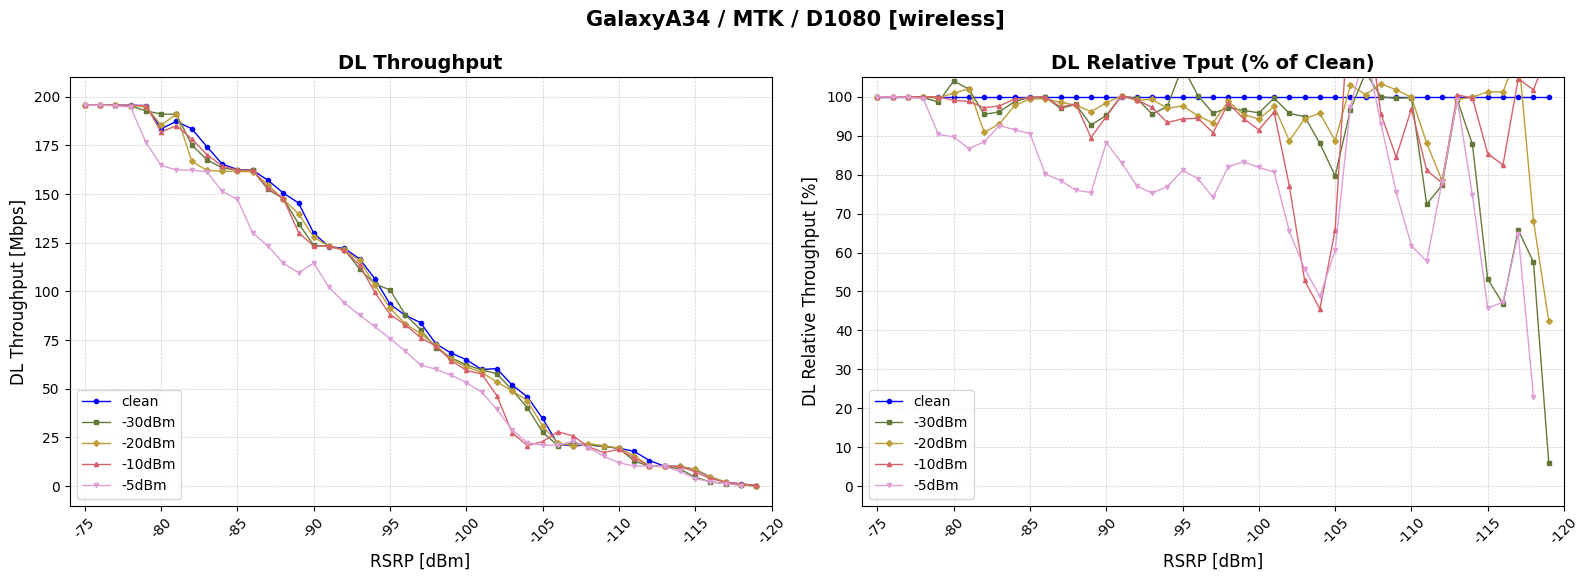

GalaxyA34-MTK-D1080 [wireless]
GalaxyA34
_Max-10_GalaxyA34.png


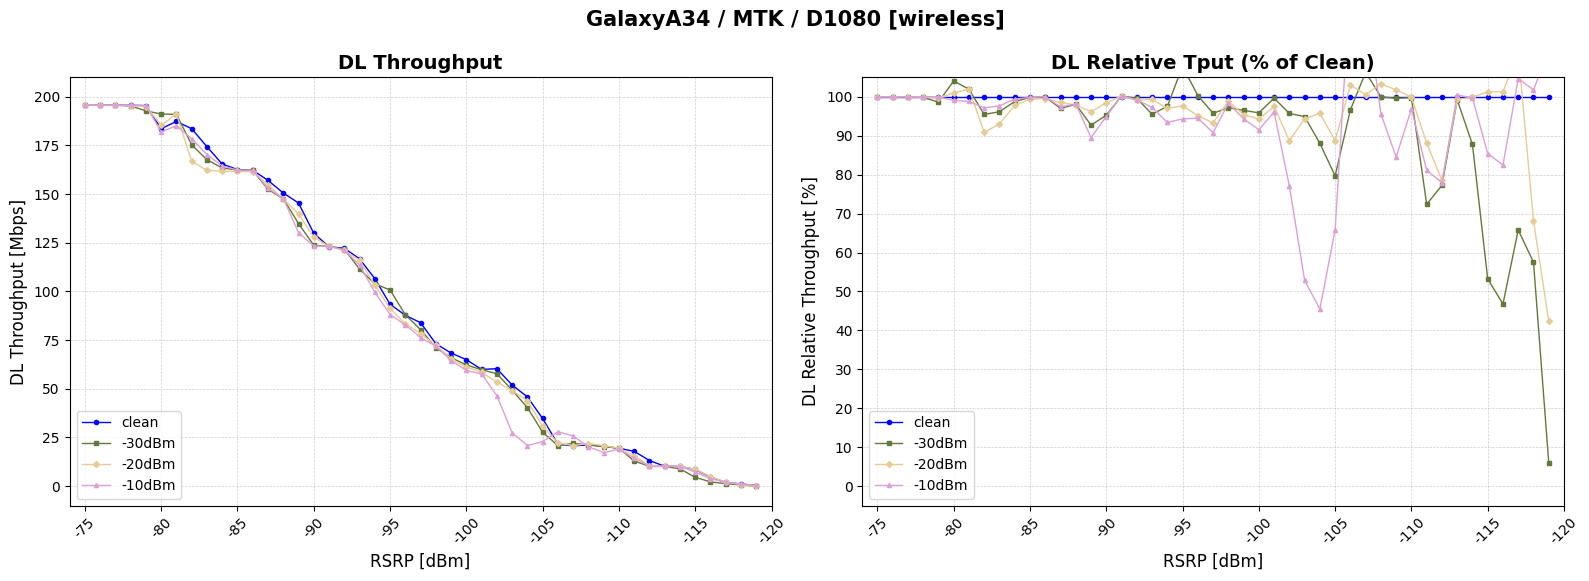

In [8]:
test_cases = [
    {"out_start": -60, "interval": 5,  "rsrp_start": None, "test_dir": "GalaxyZFold7-QCT-SM8750(x80) [wired][with BPF]"},
    {"out_start": -60, "interval": 7,  "rsrp_start": None, "test_dir": "GalaxyZFold7-QCT-SM8750(x80) [wired][without BPF]"},
    {"out_start": -40, "interval": 10, "rsrp_start": None, "test_dir": "GalaxyZFlip7-LSI-E2500 [wireless]"},
    {"out_start": -40, "interval": 10, "rsrp_start": None, "test_dir": "GalaxyZFold7-QCT-SM8750(x80) [wireless]"},
    {"out_start": -40, "interval": 10, "rsrp_start": -68,  "test_dir": "iPhone16e-Apple-A18(C1) [wireless]"},
    {"out_start": -40, "interval": 10, "rsrp_start": None, "test_dir": "iPhone15ProMax-QCT-A17pro(x70) [wireless]"},
    {"out_start": -40, "interval": 10, "rsrp_start": -76,  "test_dir": "GalaxyBuddy3-MTK-D6100 [wireless]"},
    {"out_start": -40, "interval": 10, "rsrp_start": -72,  "test_dir": "GalaxyTabS10Plus-MTK-D9300 [wireless]"},
    {"out_start": -40, "interval": 10, "rsrp_start": -70,  "test_dir": "GalaxyA34-MTK-D1080 [wireless]"},
]
dfs = {}
for tc in test_cases:
    out_start = tc['out_start']
    interval = tc['interval']
    rsrp_start = tc['rsrp_start']
    test_dir = tc['test_dir']

    if 'wireless' in test_dir:
        plot_tput(test_dir=test_dir, out_start=out_start, interval=interval, rsrp_start=rsrp_start, rsrp_class='all', Max5=True)
        plot_tput(test_dir=test_dir, out_start=out_start, interval=interval, rsrp_start=rsrp_start, rsrp_class='all', Max5=False)
    else:
        plot_tput(test_dir=test_dir, out_start=out_start, interval=interval, rsrp_start=rsrp_start, rsrp_class='all', Max5=None)